# Imports

In [ ]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import Activation,Flatten,Dense,Dropout,Embedding,Bidirectional,LSTM
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt

import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Bidirectional,SpatialDropout1D
from keras.layers.embeddings import Embedding

from sklearn.model_selection import KFold
import gc
import numpy as np
import keras.backend as K

import numpy as np
import pandas as pd
import seaborn as sb
import math

import os
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout
#from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing functions

In [ ]:
!git clone https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 98 (delta 6), reused 15 (delta 3), pack-reused 69
Unpacking objects: 100% (98/98), done.


In [ ]:
cd "/content/bengali-stemmer"

/content/bengali-stemmer


In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()

In [ ]:
!pip install bnlp_toolkit

     |████████████████████████████████| 23.9MB 107kB/s 
     |████████████████████████████████| 1.2MB 39.7MB/s 
     |████████████████████████████████| 747kB 32.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from bnlp.corpus import stopwords, punctuations
stopwordsBNLP = stopwords
print(len(stopwordsBNLP))
print(punctuations)

punkt not found. downloading...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
398
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~।ঃ


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
from bnlp.corpus.util import remove_stopwords
from bnlp import NLTKTokenizer

def removeForeign(word):
  a = "".join(i for i in word if 2432 <= ord(i) <= 2559)
  return a

def makeRemoveHyperLink(text):
  result = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
  return result

def MakeHTMLremove(text):
  '''
  result = re.compile('(<.*?>)')
  result = result.sub(r'', text) 
  '''
  cleancode = re.compile('<code>.*?</code>')
  cleanr = re.compile('<.*?>')
  cleanentity = re.compile('&.*;')
  cleantext = re.sub(cleancode, '', text)
  cleantext = re.sub(cleanr, ' ', cleantext)
  cleantext = re.sub(cleanentity, ' ', cleantext)
  
  return cleantext

def cleaning(updated):
  
  #html remove
  updated= updated.apply(lambda x: MakeHTMLremove(x))
  #hyperlink remove
  updated = updated.apply(lambda x: makeRemoveHyperLink(x))
  # tokenizer
  bnltk = NLTKTokenizer()
  updated = updated.apply(lambda x: bnltk.word_tokenize(x))
  # remove punctuations
  updated = updated.apply(lambda x: [item for item in x if item not in punctuations])
  # remove stop words
  updated = updated.apply(lambda x: [item for item in x if item not in stopwordsBNLP])
  # remove foreign words
  updated = updated.apply(lambda x: [ removeForeign(item) for item in x ])
  # stripping
  updated = updated.apply(lambda x: [item.strip() for item in x ])
  # remove numbers
  updated = updated.apply(lambda x: [re.sub(r'[০১২৩৪৫৬৭৮৯\.]+', '', item) for item in x ])
  # stemming
  updated = updated.apply(lambda x: [stemmer.stem_word(item) for item in x ])
  # stripping
  updated = updated.apply(lambda x: [item.strip() for item in x ])
  
  
  return updated

# Data Loading and preparation

In [ ]:
dfTrain= pd.read_csv('/content/drive/MyDrive/FakeNews/FakeNewsDetection Dataset/training.csv')
print("df1.shape: ",dfTrain.shape)
dfVal= pd.read_csv('/content/drive/MyDrive/FakeNews/FakeNewsDetection Dataset/val.csv')
print("df2.shape: ",dfVal.shape)
dfTest= pd.read_csv('/content/drive/MyDrive/FakeNews/FakeNewsDetection Dataset/test.csv')
print("df3.shape: ",dfTest.shape)

df1.shape:  (2787, 18)
df2.shape:  (200, 18)
df3.shape:  (200, 18)


In [ ]:
#Merging multiple csvs to make one train/test set
if False:
  df1= pd.read_csv('/content/drive/MyDrive/FakeNews/train1.csv', engine='python', encoding='utf-8')
  print("df1.shape: ",df1.shape)
  df2= pd.read_csv('/content/drive/MyDrive/FakeNews/train2.csv', engine='python', encoding='utf-8')
  print("df2.shape: ",df2.shape)
  df3= pd.read_csv('/content/drive/MyDrive/FakeNews/train3.csv', engine='python', encoding='utf-8')
  print("df3.shape: ",df3.shape)
  df4= pd.read_csv('/content/drive/MyDrive/FakeNews/train4.csv', engine='python', encoding='utf-8')
  print("df4.shape: ",df4.shape)
  dfTrain = pd.concat([df1, df2, df3, df4])
  print("dfTrain shape: ",dfTrain.shape)

  df5= pd.read_csv('/content/drive/MyDrive/FakeNews/test1.csv', engine='python', encoding='utf-8')
  print("df5.shape: ",df5.shape)
  df6= pd.read_csv('/content/drive/MyDrive/FakeNews/test2.csv', engine='python', encoding='utf-8')
  print("df6.shape: ",df6.shape)
  dfTest = pd.concat([df5, df6])
  print("dfTest shape: ",dfTest.shape)

In [ ]:
#using only one csv each to create test/train dataset
if False:
  dfTrain= pd.read_csv('/content/drive/MyDrive/FakeNews/roberta_train_val.csv', engine='python', encoding='utf-8')
  print("dfTrain.shape: ",dfTrain.shape)
  dfTest= pd.read_csv('/content/drive/MyDrive/FakeNews/roberta_test.csv', engine='python', encoding='utf-8')
  print("dfTest.shape: ",dfTest.shape)


In [ ]:
dfTrain.head()

,Page Name,Page Category,Page Admin Top Country,Page Description,Post Created,Post Created Date,Post Created Time,Type,Video Share Status,URL,Message,Link,Final Link,Image Text,Link Text,Description,Label,
0,Mustaque Ahmed Ruhi,PERSON,BD,"Mustaque Ahmed Ruhi,Former Member of Banglades...",2020-09-30 01:02:47 BDT,2020-09-30,1:02:47,Link,\n\n\n\n\n\n\n\n\n\n\n\n\n\n,https://www.facebook.com/1787139651426760/post...,দেশে হৃদরোগজনিত মৃত্যু এবং অসুস্থতার চিত্র অত্...,https://www.bangladeshershomoy.com/%e0%a6%a6%e...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n,\n\n\n\n\n\n\n\n\n\n\n\n\n\n,দেশে বছরে হৃদরোগে পৌনে ৩ লাখ মানুষের মৃত্যু,দেশে হৃদরোগজনিত মৃত্যু এবং অসুস্থতার চিত্র অত্...,1,NaN
1,পাবলিক বিশ্ববিদ্যালয়ের ছাত্র আমরা,PERSON,BD,আমাদের পেইজে স্বাগতম। আপনার বিশ্ববিদ্যালয়ের তথ...,2020-08-03 19:11:09 BDT,2020-08-03,19:11:09,Status,NaN,https://www.facebook.com/526864114090955/posts...,মনে হচ্ছে তাওয়ার উপর উঠে বসে আছি :/ কে জানি বল...,NaN,NaN,NaN,NaN,NaN,0,NaN
2,SylhetToday24,TOPIC_NEWSPAPER,BD,Leading online news portal of Bangladesh,2020-12-09 13:17:56 BDT,2020-12-09,13:17:56,Link,\n\n\n\n\n,https://www.facebook.com/567967580002498/posts...,\n\n\n\n\n,https://www.sylhettoday24.news/news/details/co...,\n\n\n\n\n,\n\n\n\n\n,সিলেটের একদিনে অর্ধশত করোনা রোগী শনাক্ত,সিলেট বিভাগে গত চব্বিশ ঘণ্টায় নতুন করে আরও ৫০ ...,1,NaN
3,News18 Bangla,NEWS & MEDIA WEBSITE,IN,News18 Bangla.com is one of the India’s leadin...,2020-04-02 19:32:13 BDT,02-04-20,19:32:13,Link,NaN,https://www.facebook.com/1632290627049330/post...,সাধারণের পাশে সরকার,https://bengali.news18.com/photogallery/busine...,NaN,NaN,রেশন কার্ড আছে তো? লকডাউনে ১ হাজার টাকা দেবে স...,করোনার জেরে লকডাউন থেকে সাধারণ মানুষকে বাঁচাতে...,1,NaN
4,Bangladesh Pratidin,MEDIA_NEWS_COMPANY,BD,Bangladesh Pratidin is the Highest circulated ...,2020-09-08 11:34:56 BDT,2020-09-08,11:34:56,Link,\n\n\n\n\n\n,https://www.facebook.com/1095330173885635/post...,\n\n\n\n\n\n,http://www.bd-pratidin.com/mixter/2020/09/08/5...,https://www.bd-pratidin.com/mixter/2020/09/08/...,\n\n\n\n\n\n,"আমি গোবর ও মাটিতে জন্মেছি, করোনা ছুঁতে পারবে ন...",ভারতের মধ্যপ্রদেশ রাজ্যের নারী ও শিশু কল্যাণ ম...,0,NaN


In [ ]:
#shuffle
if False:
  dfTrain = dfTrain.sample(frac=1, random_state=42).reset_index(drop=True)
  dfTest = dfTest.sample(frac=1, random_state=42).reset_index(drop=True)
  dfTrain.head()

In [ ]:
dfTest.head()

,Page Name,Page Category,Page Admin Top Country,Page Description,Post Created,Post Created Date,Post Created Time,Type,Video Share Status,URL,Message,Link,Final Link,Image Text,Link Text,Description,Label,
0,Daily Ittefaq,MEDIA_NEWS_COMPANY,BD,The Daily Ittefaq is Bangladesh’s iconic & old...,2020-11-19 21:25:44 BDT,2020-11-19,21:25:44,Link,\n\n\n\n\n\n,https://www.facebook.com/114957138614134/posts...,হাজার কোটি টাকা দিয়ে করোনা ভাইরাসের ভ্যাকসিন আ...,https://www.ittefaq.com.bd/national/200239/%E0...,\n\n\n\n\n\n,\n\n\n\n\n\n,করোনা ভ্যাকসিনের আগাম বুকিং দিয়েছে সরকার |,হাজার কোটি টাকা দিয়ে করোনা ভাইরাসের ভ্যাকসিন আ...,1,NaN
1,Daily Ittefaq,MEDIA_NEWS_COMPANY,BD,The Daily Ittefaq is Bangladesh’s iconic & old...,2020-03-22 14:48:41 BDT,2020-03-22,14:48:41,Link,NaN,https://www.facebook.com/114957138614134/posts...,দেশেই করোনা-প্রতিরোধী পোশাক তৈরির উদ্যোগ #itte...,https://www.ittefaq.com.bd/economy/139122/%E0%...,NaN,NaN,দেশেই করোনা-প্রতিরোধী পোশাক তৈরির উদ্যোগ | অর্...,ডাক্তারদের করোনা-প্রতিরোধী পোশাকের (পিপিই) স্ব...,1,NaN
2,News Tangail,TOPIC_NEWSPAPER,BD,টাঙ্গাইল জেলার সর্বশেষ খবর সবার আগে জানতে পেইজ...,2020-09-07 15:25:34 BDT,2020-09-07,15:25:34,Link,\n\n\n\n\n\n,https://www.facebook.com/550117595040868/posts...,\n\n\n\n\n\n,https://www.newstangail.com/2020/09/07/%e0%a6%...,\n\n\n\n\n\n,\n\n\n\n\n\n,বাড়ির চেয়ে বিদ্যালয়ে করোনা আক্রান্তের ঝুঁকি কম...,প্রাথমিক বিদ্যালয়ে পড়াশোনা করা শিশু ও সেগুলোর ...,0,NaN
3,পদ্মা সেতু খবর,ACTIVITY_GENERAL,BD,পদ্মা সেতুর যে কোনো আপডেট নিউজ এবং ছবি সবার আগ...,2020-10-24 12:44:24 BDT,2020-10-24,12:44:24,Link,\n\n\n\n\n\n\n,https://www.facebook.com/1930062317219017/post...,আমেরিকায় ফের ভয়ঙ্কর রুপে করোনাঃ একদিনে আক্রান্...,http://ekusheysongbad.com/?p=74882,\n\n\n\n\n\n\n,\n\n\n\n\n\n\n,আমেরিকায় ফের ভ'য়ঙ্কর রুপে করোনাঃ একদিনে আক্রান...,আমে’রিকায় আ’বারও ভ’য়ঙ্কর হয়ে উঠেছে প্রাণঘা’তী ...,1,NaN
4,NaN,MEDIA_NEWS_COMPANY,\n\n\n\n,"bd24live.com, leading online news portal in Ba...",2020-08-10 11:27:25 BDT,2020-08-10,11:27:25,Link,\n\n\n\n,https://www.facebook.com/202041013174014/posts...,হেঁচকি কি করোনার নতুন লক্ষন ? পড়ুন বিস্তারিত...,https://www.bd24live.com/bangla/%e0%a6%b9%e0%a...,\n\n\n\n,\n\n\n\n,‘হেঁচকি’ করোনার নতুন লক্ষণ !,‘হেঁচকি’ করোনার নতুন লক্ষণ !\nঅস্বাভাবিক হেঁচক...,0,bd24live.com


In [ ]:
def memoryUsage(df, dfName):
  df.info(memory_usage="deep")
  print(f"\nNon null rows count of {dfName}\n")
  df.isnull().sum()
memoryUsage(dfTrain, "train")
memoryUsage(dfTest, "test")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Page Name               2766 non-null   object
 1   Page Category           2780 non-null   object
 2   Page Admin Top Country  2597 non-null   object
 3   Page Description        2610 non-null   object
 4   Post Created            2787 non-null   object
 5   Post Created Date       2787 non-null   object
 6   Post Created Time       2787 non-null   object
 7   Type                    2787 non-null   object
 8   Video Share Status      1653 non-null   object
 9   URL                     2787 non-null   object
 10  Message                 2629 non-null   object
 11  Link                    2643 non-null   object
 12  Final Link              1796 non-null   object
 13  Image Text              1653 non-null   object
 14  Link Text               2639 non-null   object
 15  Desc

In [ ]:
print(dfTrain.columns)
columnsToDrop = []
for column in dfTrain.columns:
  if column != 'Message' and column != 'Description' and column != 'Label' and column != 'Link Text':
    columnsToDrop.append(column)
columnsToDrop

Index(['Page Name', 'Page Category', 'Page Admin Top Country',
       'Page Description', 'Post Created', 'Post Created Date',
       'Post Created Time', 'Type', 'Video Share Status', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description', 'Label',
       ' '],
      dtype='object')


['Page Name',
 'Page Category',
 'Page Admin Top Country',
 'Page Description',
 'Post Created',
 'Post Created Date',
 'Post Created Time',
 'Type',
 'Video Share Status',
 'URL',
 'Link',
 'Final Link',
 'Image Text',
 ' ']

In [ ]:
def DropCols(df):
  df.drop(columnsToDrop, axis=1, inplace=True)
  df.head(10)
DropCols(dfTrain)
DropCols(dfTest)
print(dfTrain.columns)

Index(['Message', 'Link Text', 'Description', 'Label'], dtype='object')


In [ ]:
DropCols(dfVal)
print(dfVal.columns)

Index(['Message', 'Link Text', 'Description', 'Label'], dtype='object')


In [ ]:
def forcingType(df, cols):
  for col in cols:
    df[col] = df[col].astype(str)
forcingType(dfTrain, ['Message','Description', 'Link Text'])
forcingType(dfTest, ['Message','Description', 'Link Text'])
dfTest.head()

,Message,Link Text,Description,Label
0,হাজার কোটি টাকা দিয়ে করোনা ভাইরাসের ভ্যাকসিন আ...,করোনা ভ্যাকসিনের আগাম বুকিং দিয়েছে সরকার |,হাজার কোটি টাকা দিয়ে করোনা ভাইরাসের ভ্যাকসিন আ...,1
1,দেশেই করোনা-প্রতিরোধী পোশাক তৈরির উদ্যোগ #itte...,দেশেই করোনা-প্রতিরোধী পোশাক তৈরির উদ্যোগ | অর্...,ডাক্তারদের করোনা-প্রতিরোধী পোশাকের (পিপিই) স্ব...,1
2,\n\n\n\n\n\n,বাড়ির চেয়ে বিদ্যালয়ে করোনা আক্রান্তের ঝুঁকি কম...,প্রাথমিক বিদ্যালয়ে পড়াশোনা করা শিশু ও সেগুলোর ...,0
3,আমেরিকায় ফের ভয়ঙ্কর রুপে করোনাঃ একদিনে আক্রান্...,আমেরিকায় ফের ভ'য়ঙ্কর রুপে করোনাঃ একদিনে আক্রান...,আমে’রিকায় আ’বারও ভ’য়ঙ্কর হয়ে উঠেছে প্রাণঘা’তী ...,1
4,হেঁচকি কি করোনার নতুন লক্ষন ? পড়ুন বিস্তারিত...,‘হেঁচকি’ করোনার নতুন লক্ষণ !,‘হেঁচকি’ করোনার নতুন লক্ষণ !\nঅস্বাভাবিক হেঁচক...,0


In [ ]:
forcingType(dfVal, ['Message','Description', 'Link Text'])

In [ ]:
"""
prepend message to Description
"""
def mergingCols(df):
  print("message: ",df['Message'][20]," description: ",df['Description'][20], "link text: ", df['Link Text'][20])
  df['Description'] =  df['Message'] +" "+df['Link Text']+" "+ df['Description']
  print("mixed: ",df['Description'][20])
mergingCols(dfTrain)
mergingCols(dfTest)

message:  রোগীর সেবা দিতে গিয়ে গত ৯ এপ্রিল তিনি করোনায় আক্রান্ত হয়ে ছিলেন...  description:  কোভিড-১৯কে প্রাণঘাতী বলা হলেও ডা. আসিফুল হক তা মানতে রাজি নন। কারণ কঠিন লড়াইয়ে করোনা তার কাছে পরাজিত হয়েছে। রোগীর সেবা দিতে গিয়ে করোনাভাইরাসে আক্রান্ত হওয়া চট্টগ্রামের এই চিকিৎসক জানিয়েছেন, দৃঢ় মনোবল আর সরকারের নির্দেশনা ও আইসোলেশন মেনে তিনি এখন সুস্থ।
ডা. আসিফুল হকের বাড়ি চট্টগামের বাঁশখালীর বৈলছড়িতে। ব্যাংক কর্মকর্তা বাবা মাহমুদুল হকের চার সন্তানের মধ্যে আসিফুল দ্বিতীয়। চট্টগ্রাম মেডিক্যাল কলেজের ৫২ তম ব্যাচের এই শিক্ষার্থী গত বছর ১১ ডিসেম্বর নিজ উপজেলা স্বাস্থ্য কমপ্লেক্সে যোগদান করেন।
ওই হাসপাতালেই রোগীর সেবা করতে গিয়ে অসুস্থ হয়ে পড়ে ছিলেন আসিফুল হক। ৯ এপ্রিল তার প্রথমে সর্দি ও কাশি হয়। ১১ এপ্রিলে গায়ে জ্বর আসে। ১২ এপ্রিল তিনি নিজেই ফৌজদারহাট বাংলাদেশ ইনস্টিটিউট অব ট্রপিক্যাল ইনফেকশনাস ডিজিসেজ এ (বিআইটিআইডি) নমুনা পরীক্ষা করান। ১৪ এপ্রিল তার করোনা ভাইরাস পজেটিভ আসে।
এর পরই বৈলছড়ির নিজ বাড়ি ও আত্মীয়ের বাড়ি ও শহরের কাতাল গঞ্জের বাসাসহ ৫টি বাড়ি ও বাঁশখালীর একটি বেসরকারী হাসপাতাল লকডাউন করা হয়। 

In [ ]:
mergingCols(dfVal)

message:  কোভিড-১৯ এ আক্রান্ত হয়েছেন গাজীপুর-২ আসনের এমপি যুব ও ক্রীড়া প্রতিমন্ত্রী জাহিদ আহসান রাসেল।  description:  প্রতিমন্ত্রী জাহিদ আহসান করোনায় আক্রান্ত
কোভিড-১৯ এ আক্রান্ত হয়েছেন গাজীপুর-২ আসনের এমপি যুব ও ক্রীড়া প্রতিমন্ত্রী জাহিদ আহসান রাসেল। শনিবার জাতীয় সংসদের পক্ষ থেকে তার নমুনা সংগ্রহ করা হয়। রোববার তার শরীরে করোনাভাইরাস শনাক্ত হয়।
সংসদ মেডিকেল সেন্টারের ডা. মো. জাহিদ বলেন, গতকাল যাদের নমুনা নেয়া হয়েছে তাদের মধ্যে শুধু একজন এমপি করোনা পজেটিভ। তবে সংসদের কয়েকজন কর্মকর্তা-কর্মচারী করোনায় আক্রান্ত হয়েছে। আজ মুঠোফোনে বার্তা পাঠিয়ে তাদেরকে বিষয়টি জানানো হয়েছে।
বাংলাদেশের ইতিহাসে সংসদের প্রথম বিশেষ অধিবেশন শুরু হয় ৮ নভেম্বর। জাতির পিতা বঙ্গবন্ধু শেখ মুজিবুর রহমানের জন্মশতবর্ষ উপলক্ষে আয়োজিত এই অধিবেশনে এখন বঙ্গবন্ধুকে নিয়ে আলোচনা চলছে। আজ এ আলোচনা শেষ হওয়ার কথা রয়েছে।
এই অধিবেশন উপলক্ষে নমুনা নেয়ার পর অত্যন্ত ১৬ জনের শরীরে করোনা শনাক্ত হয়েছে। link text:  করোনাভাইরাসে আক্রান্ত প্রতিমন্ত্রী জাহিদ আহসান
mixed:  কোভিড-১৯ এ আক্রান্ত হয়েছেন গাজীপুর-২ আসনের এমপি যুব ও ক্রীড়া প্রতিমন

In [ ]:
"""
Removing duplicate rows
"""
def removeDuplicateRows(df):
  print("Unique Content :",len(list(set(df['Description']))))
  print("Total rows :",len(df)) 
  df.drop_duplicates(subset ="Description", 
                      keep = "first", inplace = False)
removeDuplicateRows(dfTrain)
removeDuplicateRows(dfTest)
removeDuplicateRows(dfVal)

Unique Content : 2786
Total rows : 2787
Unique Content : 200
Total rows : 200
Unique Content : 200
Total rows : 200


In [ ]:
if False:
  from sklearn.model_selection import train_test_split
  x_train,x_val,y_train,y_val=train_test_split(dfTrain['Description'], dfTrain['Label'], test_size=0.2)
  print(x_train.shape)
  print(x_val.shape)
  print(y_train.shape)
  print(y_val.shape)
  x_train = x_train.reset_index(drop=True)
  x_val = x_val.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)
  y_val = y_val.reset_index(drop=True)

In [ ]:
def preprocess(df):
  preprocessed=cleaning(df.copy())
  preprocessed = preprocessed.apply(lambda x: "".join(" "+item for item in x))
  return preprocessed

preprocessed_train = preprocess(dfTrain['Description'])
print('train: ',preprocessed_train[0])
preprocessed_val = preprocess(dfVal['Description'])
print('\nval: ',preprocessed_val[0])
preprocessed_test = preprocess(dfTest['Description'])
print('\ntest: ',preprocessed_test[0])


train:   দেশ হৃদরোগজনিত মৃত্যু অসুস্থত চিত্র অত্যন্ত উদ্বেগজনক বাংলাদেশ বছর  লাখ   হৃদরোগ মা  দশমিক  শতাংশ দায়ী ট্রান্সফ্যাট কার্ডিওভাসকুল ডিজিজ হৃদরোগ পৃথিবীব্যাপী মৃত্যুর একক হিসেব শীর্ষ যেসব কারণ হৃদরোগ ঝুঁকি বাড় ট্রান্সফ্যাট তারমধ্য অন্যতম আশঙ্ক কথা ট্রান্সফ্যাটজনিত হৃদরোগ মৃত্যুর সর্বাধিক ঝুঁকিপূর্ণ টি দেশ র বাংলাদেশ পারশিয়া হাইড্রোজেনেটেড অয় পিএইচ  অনিয়ন্ত্রিত খাদ্য উচ্চ মাত্রা ট্রান্সফ্যাট গ্রহণ অসংক্রামক রোগ মৃত্যুঝুঁকি বহুগুণ বাড়ি তুল বিশেষজ্ঞ জানিয় স্বাস্থ্য অধিদপ্তর হেলথ বুলেটিন  তথ্যম   সময়কাল জাতী হৃদরোগ ইনস্টিটিউট বহির্বিভাগ সেবা আসা রোগীর সংখ্যা বেড়  দশমিক  শতাংশ বাংলাদেশ প্রতিবছর য মানুষ মা যা  শতাংশ দায়ী অসংক্রামক রোগ মানবজমিন ট্রান্সফ্যাট গ্রহণ হৃদরোগ ঝুঁকির উচ্চহ ব্যাপকভাব সম্পর্কযুক্ত বিশ্ব স্বাস্থ্য সংস্থ হিসাব অনুযায়ী বিশ্ব প্রতিবছর   লাখ মানুষ হৃদরোগ মৃত্যুবরণ মৃত্যুর  কেবল ট্রান্সফ্যাট গ্রহণ কারণ হৃদরোগ আক্রান্ত হ মা যা  লাখ  মানুষ উদ্বেগজনক বিষ হৃদরোগী করোনা সংক্রমণ গুরুতর অসুস্থ হ পড় ঝুঁকি অনেকগুণ চিকিৎসক জানিয় সাম্প্রতিক বছর হৃদরোগজনিত অসুস্থতা মৃত্যু এতো দ্র

In [ ]:
def makeDatasetDFs(text, labels):
  ll=[]
  for i in range(len(text)):
    ll.append([text[i],labels[i]])
  return pd.DataFrame(ll,columns=['text','labels'])

In [ ]:
df_test = makeDatasetDFs(preprocessed_test, dfTest['Label'])
df_train = makeDatasetDFs(preprocessed_train, dfTrain['Label'])
df_val = makeDatasetDFs(preprocessed_val, dfVal['Label'])

In [ ]:
df_train.head()

,text,labels
0,দেশ হৃদরোগজনিত মৃত্যু অসুস্থত চিত্র অত্যন্ত উ...,1
1,তাওয় উঠ আ জানি বল ডিগ্রি সেলসিয়াস টেম্পারেচ ...,0
2,সিলেট একদিন অর্ধশত করোনা রোগী শনাক্ত সিলেট বি...,1
3,সাধারণ পাশ সরক রেশন কার্ড লকডাউন টাকা দেব সর...,1
4,গোবর মা জন্মে করোনা ছুঁ পারব ভারতী মন্ত্রী বা...,0


In [ ]:
df_test.head()

,text,labels
0,টাকা দি করোনা ভাইরাস ভ্যাকসিন আগাম বুকিং দি র...,1
1,দেশ করোনাপ্রতিরোধী পোশাক তৈরির উদ্যোগ ইত্তেফ...,1
2,বাড়ির চা বিদ্যাল করোনা আক্রান্ত ঝুঁকি কম গবেষ...,0
3,আমেরিকা ভয়ঙ্কর রুপ করোনাঃ একদিন আক্রান্ত আমে...,1
4,হেঁচকি করোন লক্ষন পড়ুন বিস্তারিত হেঁচকি কর...,0


In [ ]:
df_val.head()

,text,labels
0,করোনা আশ আলো শহর মসজিদ খুল দি ইরান করোনা আশ ...,1
1,হা সম ঘন্ ধা আস বিশাল গ্রহাণু জানাল নাসা হা ...,0
2,চীন ভাইরাস শনাক্ত বিশ্বজুড় ছড়ানোর শঙ্কা চীন ভ...,0
3,দেশ সাড় মানুষ ভ্যাকসিন আওত বাইর স্বাস্থ্যমন্...,1
4,করোনাভাইরাস মুক্ত থাক সারাদেশ মসজিদ দোয়া মোন...,1


# Data Oversampling

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes in training data for upsampling 
data_majority = df_train[df_train['labels'] == 1]
data_minority = df_train[df_train['labels'] == 0]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

 
# Display new class counts
print("After upsampling\n",data_upsampled.labels.value_counts(),sep = "")

majority class before upsample: (2249, 2)
minority class before upsample: (538, 2)
After upsampling
1    2249
0    2249
Name: labels, dtype: int64


In [ ]:
df_train_upsampled = data_upsampled
print(len(df_train_upsampled.index))

4498


#Model Preparation

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 225kB 9.7MB/s 
     |████████████████████████████████| 3.3MB 45.2MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 2.5MB 34.9MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
     |████████████████████████████████| 266kB 54.0MB/s 
     |████████████████████████████████| 7.8MB 16.2MB/s 
     |████████████████████████████████| 1.8MB 41.0MB/s 
     |████████████████████████████████| 133kB 52.2MB/s 
     |████████████████████████████████| 901kB 28.8MB/s 
     |████████████████████████████████| 245kB 46.2MB/s 
     |████████████████████████████████| 122kB 54.1MB/s 
     |████████████████████████████████| 112kB 52.7MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 174kB 52.4MB/s 
     |████████████████████████████████| 4.2MB 41.7MB/s 
     |████████████████████████████████| 133kB 57.0MB/s 
     |████████████████████████████████| 102kB 15.2MB/

# XLM-Roberta 

In [ ]:
model_type = "xlmroberta"
model_name = "xlm-roberta-base"


train_args = {
    "reprocess_input_data": True, #stays for now
    "overwrite_output_dir": False,
    "use_cached_eval_features": False,
    "output_dir": "/content/drive/MyDrive/Oversampling Model Output/"+model_type,
    "best_model_dir": "/content/drive/MyDrive/Oversampling Model Output/"+model_type+"/best_model",
    "use_early_stopping": False,
    # "early_stopping_delta": 0.0,
    # "early_stopping_metric": "eval_loss",
    # "early_stopping_metric_minimize" : True,
    # "early_stopping_patience" : 2,
    "evaluate_during_training": True,
    "max_seq_length": 512,
    "num_train_epochs": 10,
    "evaluate_during_training_steps": 32,
    # "wandb_project": "Fake News Fulltrain_1 RoBERTa",
    # "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": True,
    "save_eval_checkpoints": False,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "evaluate_during_training_verbose" : True
}

In [ ]:
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs


cuda_available = torch.cuda.is_available()
print(cuda_available)
# train_args["max_seq_length"] = 300
# train_args["train_batch_size"] = 32
# train_args["gradient_accumulation_steps"] = 2
# train_args["evaluate_during_training"] = True
# train_args["evaluate_during_training_steps"] = 1989
# train_args["use_early_stopping"] = True


# Create a ClassificationModel
model = ClassificationModel(model_type, model_name, args=train_args, use_cuda=cuda_available)

True


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bi

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:484: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [ ]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
history = model.train_model(df_train_upsampled, eval_df=df_val)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


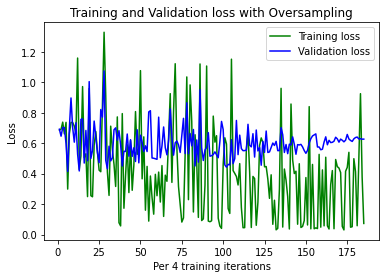

In [ ]:
import matplotlib.pyplot as plt
 
lossDataPointNum = range(1,len(history[1]['eval_loss'])+1)
plt.plot(lossDataPointNum, history[1]['train_loss'], 'g', label='Training loss')
plt.plot(lossDataPointNum, history[1]['eval_loss'], 'b', label='Validation loss')
plt.title('Training and Validation loss with Oversampling')
plt.xlabel('Per 4 training iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Oversampling Model Output/xlmroberta/train_val_loss_with_oversampling.png')
plt.show()

In [ ]:
if False:
  result, model_outputs, wrong_predictions = model.eval_model(df_test)
  predictions = np.argmax(model_outputs,axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
if False:
  print("model_output:\n\n",model_outputs)
  print("\n\npredictions: \n\n",predictions)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
if False:
  print(predictions)
  print(df_val['labels'])
  print(accuracy_score(df_test['labels'],predictions))

In [ ]:
Model = ClassificationModel(
    "xlmroberta", "/content/drive/MyDrive/Oversampling Model Output/xlmroberta/best_model"
)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:484: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [ ]:
predictions, raw_outputs = Model.predict(df_test['text'].tolist())

In [ ]:
print(predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(df_test['labels'],predictions))
print(confusion_matrix(df_test['labels'],predictions))

0.895
[[  8  15]
 [  6 171]]


In [ ]:
from sklearn import metrics

print("precision: ",metrics.precision_score(df_test['labels'],predictions))
print("recall: ",metrics.recall_score(df_test['labels'],predictions))
print("f1-score: ",metrics.f1_score(df_test['labels'],predictions))

precision:  0.9193548387096774
recall:  0.9661016949152542
f1-score:  0.9421487603305785


In [ ]:
matrix = classification_report(df_test['labels'],predictions)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.57      0.35      0.43        23
           1       0.92      0.97      0.94       177

    accuracy                           0.90       200
   macro avg       0.75      0.66      0.69       200
weighted avg       0.88      0.90      0.88       200



# BERT

In [ ]:
model_type = "bert"
model_name = "bert-base-multilingual-cased"


train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": False,
    "output_dir": "/content/drive/My Drive/Fake News/Transformer/output/"+model_type,
    "best_model_dir": "/content/drive/My Drive/Fake News/Transformer/output/"+model_type+"/best_model",
    "use_early_stopping": True,
    "early_stopping_delta": 0.0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize" : True,
    "early_stopping_patience" : 2,
    "evaluate_during_training": True,
    "max_seq_length": 256,
    "num_train_epochs": 2,
    "evaluate_during_training_steps": 4,
    # "wandb_project": "Fake News Fulltrain_1 RoBERTa",
    # "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "evaluate_during_training_verbose" : True
}

In [ ]:
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs

cuda_available = torch.cuda.is_available()

# train_args["max_seq_length"] = 300
# train_args["train_batch_size"] = 32
# train_args["gradient_accumulation_steps"] = 2
# train_args["evaluate_during_training"] = True
# train_args["evaluate_during_training_steps"] = 1989
# train_args["use_early_stopping"] = True


# Create a ClassificationModel
model = ClassificationModel(model_type, model_name, args=train_args, use_cuda=cuda_available)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
model.train_model(df_train, eval_df=df_val)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(20,
 {'auprc': [0.9198703001296946,
   0.9371341653499763,
   0.9078653010173805,
   0.894840723555814,
   0.873800561101411],
  'auroc': [0.7369281045751634,
   0.7728758169934641,
   0.7312091503267975,
   0.7124183006535947,
   0.6813725490196079],
  'eval_loss': [0.5696222285429636,
   0.4447893425822258,
   0.5346883088350296,
   0.4578511727352937,
   0.45531773567199707],
  'fn': [0, 0, 0, 0, 0],
  'fp': [17, 17, 17, 17, 17],
  'global_step': [4, 8, 12, 16, 20],
  'mcc': [0.0, 0.0, 0.0, 0.0, 0.0],
  'tn': [0, 0, 0, 0, 0],
  'tp': [72, 72, 72, 72, 72],
  'train_loss': [0.7447702884674072,
   0.2730419337749481,
   0.6352287530899048,
   0.6971256136894226,
   0.7735500931739807]})

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)
predictions = np.argmax(model_outputs,axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print("model_output:\n\n",model_outputs)
print("\n\npredictions: \n\n",predictions)

model_output:

 [[-0.87003177  0.824256  ]
 [-0.87612873  0.77276945]
 [-0.89236784  0.73991317]
 [-0.86020297  0.76040763]
 [-0.78964013  0.71377563]
 [-0.8962819   0.77079004]
 [-0.83744282  0.68338543]
 [-0.83286506  0.80332261]
 [-0.92015493  0.77487355]
 [-0.89280313  0.81380981]
 [-0.80160695  0.76560479]
 [-0.86916107  0.74889642]
 [-0.86907989  0.73985368]
 [-0.84700984  0.74491817]
 [-0.86944824  0.76039934]
 [-0.85833865  0.77723962]
 [-0.86587882  0.76236403]
 [-0.83559114  0.7275638 ]
 [-0.84762532  0.77472514]
 [-0.84122664  0.67637092]
 [-0.86095494  0.7781626 ]
 [-0.81036323  0.78870231]
 [-0.85753304  0.7310974 ]
 [-0.89655018  0.82162076]
 [-0.87461919  0.76402807]
 [-0.83339149  0.72017545]
 [-0.88785124  0.76743323]
 [-0.88432646  0.76616526]
 [-0.85732335  0.53434724]
 [-0.88304335  0.73220819]
 [-0.85052377  0.75133282]
 [-0.89875025  0.77357429]
 [-0.88623863  0.81937379]
 [-0.7967003   0.71413916]
 [-0.80995405  0.75707608]
 [-0.76366031  0.6127553 ]
 [-0.8274561

In [ ]:
from sklearn.metrics import accuracy_score
print(predictions)
print(accuracy_score(df_test['labels'],predictions))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6333333333333333


In [ ]:
predictions, raw_outputs = model.predict(df_test['text'].tolist())

In [ ]:
print(predictions)
print(accuracy_score(df_test['labels'],predictions))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6333333333333333
